In [2]:
# Environment Setup
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
sym.init_printing(use_latex='mathjax')
from IPython.display import display, Markdown, Math

# Motor Modeling

Torque is controlled via current, but when we set the PWM values on the motor coils we are actually dictating the voltage. To control current with voltage, we need a motor model of how voltage (the parameter we can actually control) affects current (the parameter we want to control).


## Constants:

$J_m$: $\text{kg} \text{m}^2$ Rotational moment of inertia

$B_m$: Friction coefficient. (Scalar, dimensionless)

$L_m$: $\text{Henrys}$ inductance of the motor coils

$R_m$: $\text{Ohms}$ resistance of the motor coils

$K_v$: $\frac{\text{RPM}}{\text{V}}$ motor constant that shows up more commonly.

$K_m$: $\frac{60}{2 \pi K_v}$ motor torque constant

$G_{iv} = \frac{\text{output}}{\text{input}} = \frac{I(s)}{V(s)}$

In [104]:
# Create the Voltage-to-Current Transfer Function in Sympy
s = sym.symbols('s')
t = sym.symbols('t', real=True)
Jm, Bm, Lm, Rm, Km, Vm = sym.symbols('J_m, B_m, L_m, R_m, K_m, V_m', real=True)
kv = 25 # rpm  per volt

givens = \
{
    Jm: 0.01, # rotational moment of inertia. Random guess, but just influences time until steady-state.
    Bm: 0.005, # Friction Coefficient. 3 decimal places is a reasonable value for ball bearings.
    Lm: 0.001,
    Rm: 15,
    Km: 60./(2 * sym.pi * kv),
}

# L(Output)/L(Input) = I(s)/V(s)
Tf = (s * Jm + Bm)/(s**2 * Jm*Lm + s*(Jm*Rm + Bm*Lm) + (Bm*Rm + Km**2))
display(Tf)

num,den = Tf.subs(givens).as_numer_denom()
num_coeffs = sym.Poly(num.subs(givens).evalf(), s).coeffs()
den_coeffs = sym.Poly(den.subs(givens).evalf(), s).coeffs()

# Convert out of Sympy Float to normal float.
num_coeffs = [float(c) for c in num_coeffs]
den_coeffs = [float(c) for c in den_coeffs]

                Bₘ + Jₘ⋅s                 
──────────────────────────────────────────
               2     2                    
Bₘ⋅Rₘ + Jₘ⋅Lₘ⋅s  + Kₘ  + s⋅(Bₘ⋅Lₘ + Jₘ⋅Rₘ)

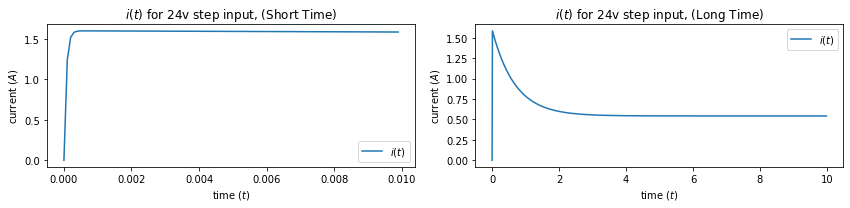

In [108]:
# Numerically Simulate the Transfer Function
from scipy.signal import lsim
step_voltage = 24
t_short = np.linspace(0, 0.01,100, endpoint=False) # 0.0, 0.01, ...
t_long = np.linspace(0, 10, 1000, endpoint=False)
sim_times = [t_short, t_long]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
titles = [rf"$i(t)$ for ${step_voltage}$v step input, (Short Time)",
          rf"$i(t)$ for ${step_voltage}$v step input, (Long Time)"]

for ax, t_, title in zip(axes, sim_times, titles):
    u_ = np.ones_like(t_) * step_voltage # step input.
    t_, y_, x_ = lsim((num_coeffs, den_coeffs), u_, t_)
    ax.plot(t_, y_, label=rf"$i(t)$")
    ax.set_title(title)
    ax.set_xlabel(r"time $(t)$")
    ax.set_ylabel(r"current $(A)$")
    ax.legend()
fig.tight_layout()

Do the above graphs make sense?

Yes! Starting from an idle motor (rpm = 0), the transient behavior is for current to follow the voltage immediately. But, once the motor starts spinning, it starts generating a Back-EMF voltage that opposes the input voltage. This Back-EMF increases until we hit equilibrium. 

Let's make a few observations:

1. Increasing the voltage (to 18v or 24v) produces current values that make more sense with [this gimbal motor](https://indonesian.alibaba.com/product-detail/gbm5208h-200t-dc-brushless-gimbal-motor-1600101101528.html) with similar specs to our model.
1. A smaller moment of inertia means the motor will spin up faster.
1. A smaller internal resistance means the input current will be higher
1. A smaller amount of friction means that the steady-state current would asymptotically approach zero since the back-EMF and input voltage would more closely match each other.

---

## State Space Representation


In state space, our differential equation takes on the form:
$$
f(\vec{x}, \vec{u}) = \vec{x}'
$$

Here let's let our state and inputs be:
\begin{align}
\vec{x} = 
\begin{bmatrix}
\theta \\
\theta' \\
i \\
\end{bmatrix}
&&
\vec{u} = \begin{bmatrix} V_m \end{bmatrix}
\end{align}

Using our equations from [subms](http://subms.com/tutorials/motor_modeling), we get:

$$
f(\vec{x}, \vec{u}) = 
\begin{bmatrix}
\theta' \\
\frac{K_m}{J_m}i - \frac{B_m}{J_m}\theta'\\
-\frac{R_m}{L_m}i - \frac{K_m}{L_m}\theta' + \frac{1}{L_m}V_m
\end{bmatrix}
$$

The above system is already linear, which is nice since we're not approximating when we put it into $A\vec{x} + B\vec{u}$ form. In that form, we get:

$$
\begin{bmatrix}
\theta' \\
\theta'' \\
i'
\end{bmatrix} =
\begin{bmatrix}
0 & 1 & 0 \\
0 & -\frac{B_m}{J_m} & \frac{K_m}{J_m}\\
0 & -\frac{K_m}{L_m} & -\frac{R_m}{L_m}
\end{bmatrix}
\begin{bmatrix}
\theta \\
\theta' \\
i
\end{bmatrix}
+
\begin{bmatrix}
0 \\
0\\
\frac{1}{L_m}
\end{bmatrix}
\begin{bmatrix}
V_m
\end{bmatrix}
$$

In [123]:
# Prof Burden's Numerical Simulation fn
# from: https://colab.research.google.com/github/sburden/547-21wi/blob/master/547_lec.ipynb#scrollTo=x-AAJZ-RNxS-
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

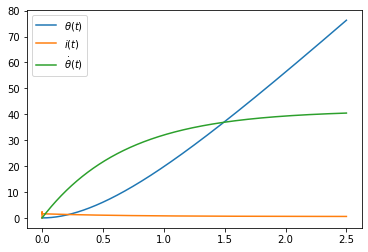

In [124]:
i, i_prime, theta, theta_prime = sym.symbols("i, i', \theta, \\theta'")

kv = 25 # rpm  per volt

givens = \
{
    Jm: 0.01, # rotational moment of inertia
    Bm: 0.005, # Friction Coefficient
    Lm: 0.001,
    Rm: 15,
    Km: 60./(2 * sym.pi * kv),
}

A = sym.Matrix([[0, 1, 0], [0, -Bm/Jm, Km/Jm], [0, -Km/Lm, -Rm/Lm]])
B = sym.Matrix([[0], [0], [1/Lm]])

x = sym.Matrix([[theta], [theta_prime], [i]])
u = sym.Matrix([Vm])

f = A*x + B*u

lambda_f = sym.lambdify([t, (theta, theta_prime, i), Vm], f.subs(givens))
lambda_f_ = lambda t,x,u : lambda_f(t, x, u).flatten()
lambda_u = lambda t: 24 # constant voltage of 24 for all time.

sim_time =2.5
x0 = np.array([0, 0, 0]) # initial condition for the lambdified function

t_, x_ = numerical_simulation(lambda_f_, sim_time, x0, ut=lambda_u)

plt.plot(t_, x_[:,0], label=r"$\theta(t)$")
plt.plot(t_, x_[:, 2], label=r"$i (t)$")
plt.plot(t_, x_[:, 1], label=r"$\dot{\theta}(t)$")
plt.legend()
plt.show()

## Resources
1. [SUBMS: Motor Modeling](http://subms.com/tutorials/motor_modeling)
1. https://aleksandarhaber.com/modeling-a-dc-motor-and-matlab-simulation/
1. [Motor Constants](https://en.wikipedia.org/wiki/Motor_constants)

## Scratchwork

                Bₘ + Jₘ⋅s                 
──────────────────────────────────────────
               2     2                    
Bₘ⋅Rₘ + Jₘ⋅Lₘ⋅s  + Kₘ  + s⋅(Bₘ⋅Lₘ + Jₘ⋅Rₘ)

⎛ t                  ⎞  -t     
⎝ℯ  + sin(t) - cos(t)⎠⋅ℯ  ⋅θ(t)
───────────────────────────────
               2               

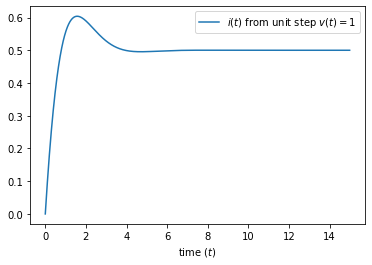

In [62]:
s = sym.symbols('s')
t = sym.symbols('t', real=True)
Jm, Bm, Lm, Rm, Km, Vm = sym.symbols('J_m, B_m, L_m, R_m, K_m, V_m', real=True)

givens = \
{
    Jm: 1,#1.,
    Bm: 1,#0.5,
    Lm: 1, # Inv L transform breaks if we use floats.
    Rm: 1,
    Km: 1
}


# L(Output)/L(Input) = I(s)/V(s)
Tf = (s * Jm + Bm)/(s**2 * Jm*Lm + s*(Jm*Rm + Bm*Lm) + (Bm*Rm + Km**2))
display(Tf)

# L(unit step)
U = 1/s


# Create Callable Function for Plotting.
# Sympy needs help finding the heaviside function.
modules = [{'Heaviside': lambda x: np.heaviside(x, 1)}, 'numpy']
# Create a callable function from given numerical values.
unit_step_response = sym.inverse_laplace_transform((Tf*U).subs(givens), s, t)

display(unit_step_response)
lambda_f = sym.lambdify(t, unit_step_response, modules=modules)

time_series = np.arange(0, 15, 0.01)
f_series = np.array([lambda_f(t) for t in time_series])

plt.plot(time_series, f_series, label=r"$i(t)$ from unit step $v(t) = 1$")
plt.xlabel("time ($t$)")
plt.legend()
plt.show()

   s + 1    
────────────
 2          
s  + 2⋅s + 2

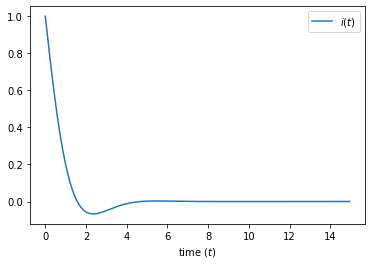

In [4]:
display(Tf.subs(givens))
impulse_response = sym.inverse_laplace_transform(Tf.subs(givens), s, t).evalf()

lambda_f = sym.lambdify(t, impulse_response, modules=modules)
time_series = np.arange(0, 15, 0.05)
f_series = np.array([lambda_f(t) for t in time_series])

plt.plot(time_series, f_series, label=r"$i(t)$")
plt.xlabel("time ($t$)")
plt.legend()
plt.show()